In [3]:
from google.colab import files
uploadImg = files.upload()

Saving apple.jpg to apple.jpg
Saving mask.jpg to mask.jpg
Saving orange.jpg to orange.jpg


(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2)

(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)


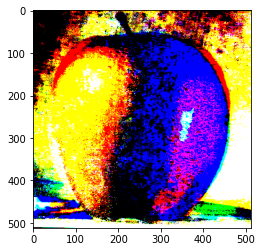

In [8]:
# install the libraries
import numpy as np
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import imageio
from PIL import Image

# create a  Binomial (5-tap) filter
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])
"""
plt.imshow(kernel)
plt.show()
"""

def interpolate(image):
  """
  Interpolates an image with upsampling rate r=2.
  """
  image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
  # Upsample
  image_up[::2, ::2] = image
  # Blur (we need to scale this up since the kernel has unit area)
  # (The length and width are both doubled, so the area is quadrupled)
  #return sig.convolve2d(image_up, 4*kernel, 'same')
  return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
  """
  Decimates an image with downsampling rate r=2.
  """
  # Blur
  #image_blur = sig.convolve2d(image, kernel, 'same')
  print(np.shape(image), np.shape(kernel))
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
  # Downsample
  return image_blur[::2, ::2]                                
               
                                      
  # here is the constructions of pyramids
def pyramids(image):
  """
  Constructs Gaussian and Laplacian pyramids.
  Parameters :
  image  : the original image (i.e. base of the pyramid)
  Returns :
  G   : the Gaussian pyramid
  L   : the Laplacian pyramid
  """
  # Initialize pyramids
  G = [image, ]
  L = []

  # Build the Gaussian pyramid to maximum depth
  while image.shape[0] >= 2 and image.shape[1] >= 2:
    image = decimate(image)
    G.append(image)

  # Build the Laplacian pyramid
  for i in range(len(G) - 1):
    L.append(G[i] - interpolate(G[i + 1]))

  return G[:-1], L

# [G, L] = pyramids(image)

# Build Gaussian pyramid and Laplacian pyramids from images A and B, also mask
# Reference: https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f
def pyramidBlending(A, B, mask):
  [GA, LA] = pyramids(A)
  [GB ,LB] = pyramids(B)
  # Build a Gaussian pyramid GR from selected region R (mask that says which pixels come from left and which from right)
  [Gmask, LMask] = pyramids(mask)
  # Form a combined pyramid LS from LA and LB using nodes of GR as weights
  # Equation: LS(i, j) = GR(I, j)*LA(I, j) + (1-GR(I, j)* LB(I, j))
  # Collapse the LS pyramid to get the final blended image
  blend = []
  for i in range(len(LA)):
    LS = np.max(Gmask[i])*LA[i] + (1-np.max(Gmask[i]))*LB[i]
    # LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
    blend.append(LS)
  return blend

# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
  rows, cols = pyramid[0].shape
  res = np.zeros((rows, cols + cols//2), dtype= np.double)
  # start the smallest pyramid so we need to reverse the order
  revPyramid = pyramid[::-1]
  stack = revPyramid[0]
  # start with the second index
  for i in range(1, len(revPyramid)):
    stack = interpolate(stack) + revPyramid[i] # upsampling simultaneously
  return stack

# https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/
# Besides pyramid Blending, we need to blend image's color
def colorBlending(img1, img2, mask):
  # split to 3 basic color, then using pyramidBlending and reconstruct it, respectively
  img1R,img1G,img1B = cv2.split(img1)
  img2R,img2G,img2B = cv2.split(img2)
  R = reconstruct(pyramidBlending(img1R, img2R, mask))
  G = reconstruct(pyramidBlending(img1G, img2G, mask))
  B = reconstruct(pyramidBlending(img1B, img2B, mask))
  output = cv2.merge((R, G, B))
  plt.imshow(output)
  imageio.imsave("appnge.png", output)

apple = imageio.imread('apple.jpg')
orange = imageio.imread('orange.jpg')
mask = cv2.imread('mask.jpg', 0)
colorBlending(apple, orange, mask)
